# Appendix 3: Yibal Processing

### Libraries

In [1]:
import pylab as plt
%matplotlib inline
import numpy as np
import sys
import glob
import gdal
import matplotlib.cm as cm
import os
import datetime
import matplotlib.patches as mpatches

### Ploting deformation maps

/home/moath/anaconda3/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


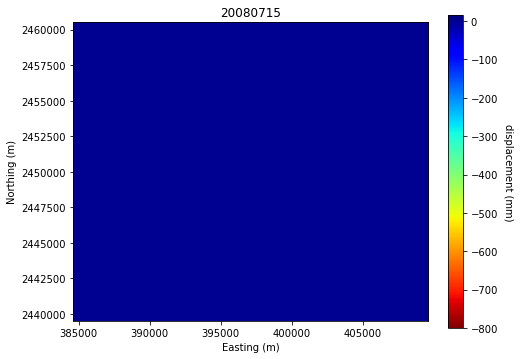

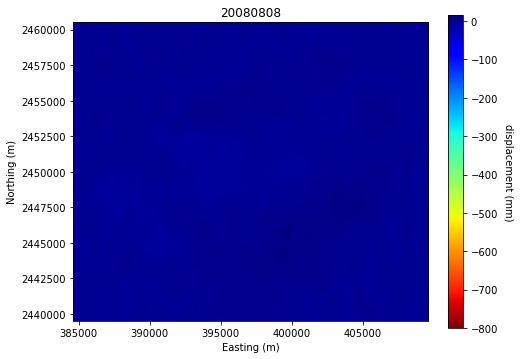

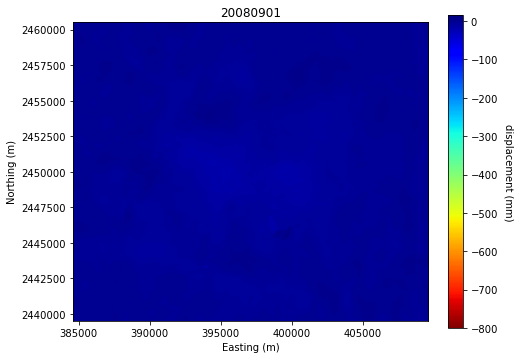

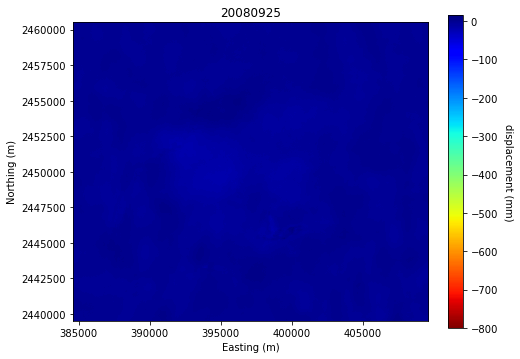

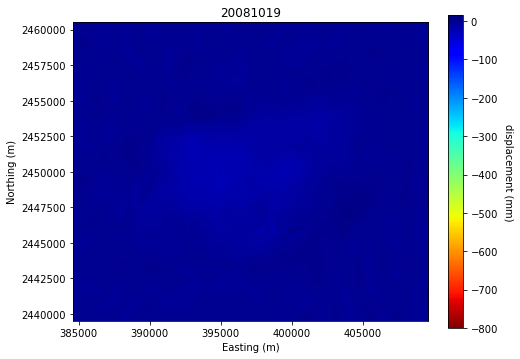

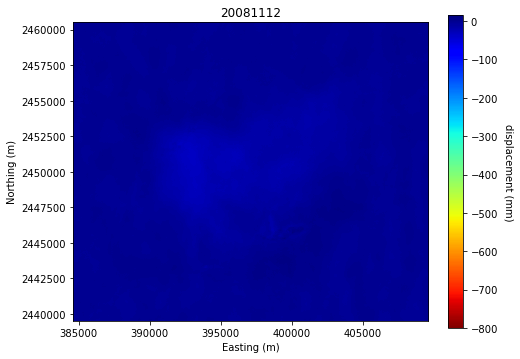

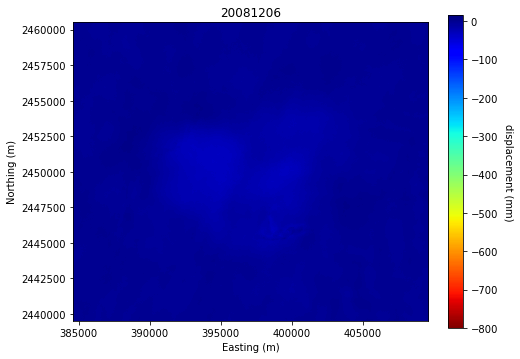

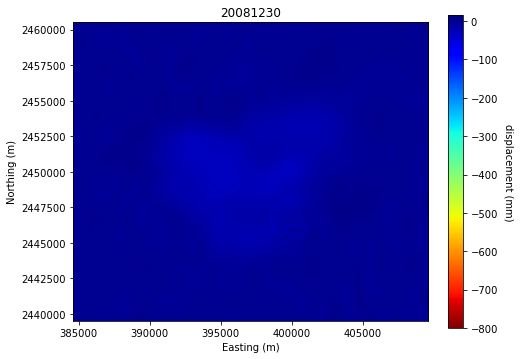

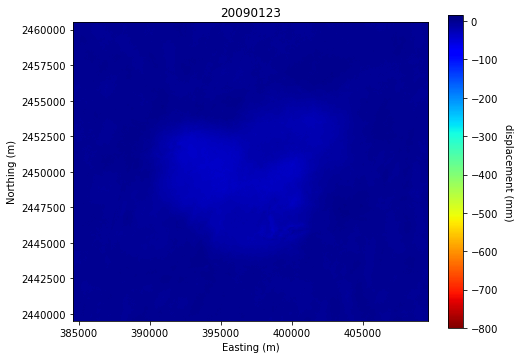

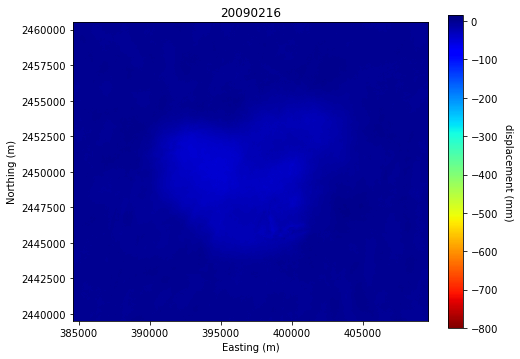

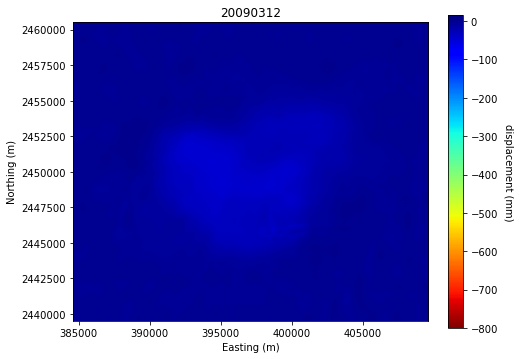

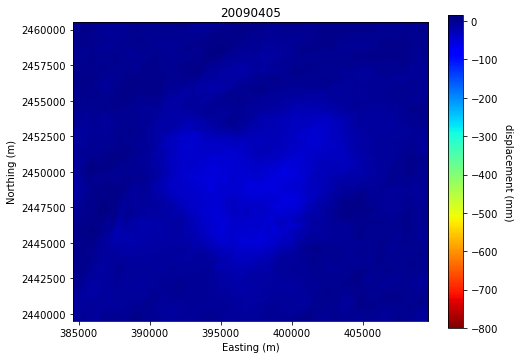

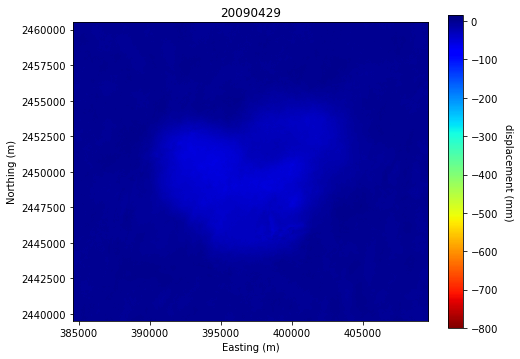

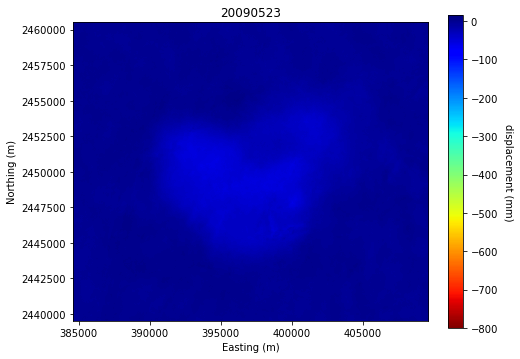

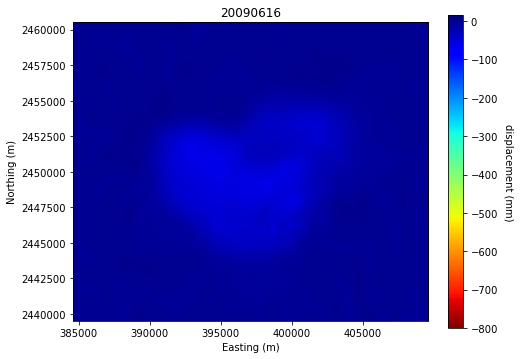

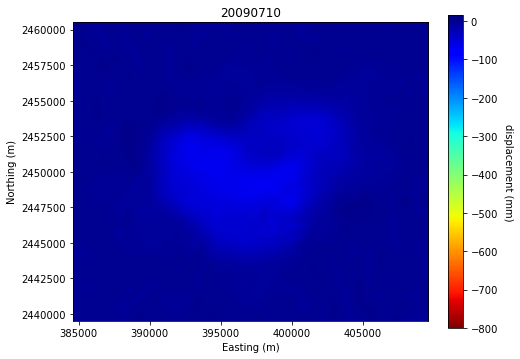

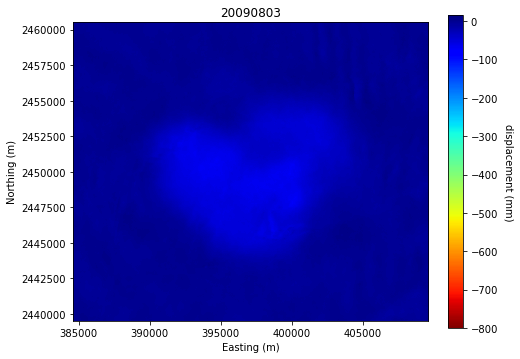

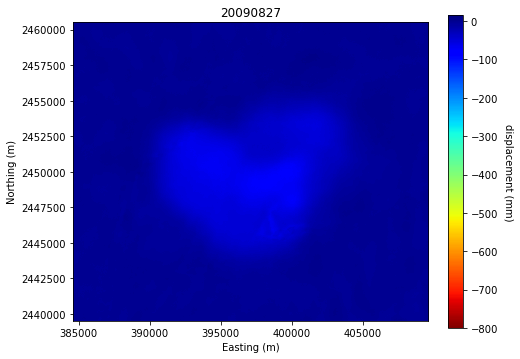

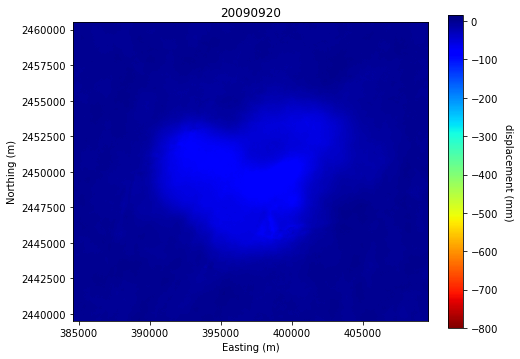

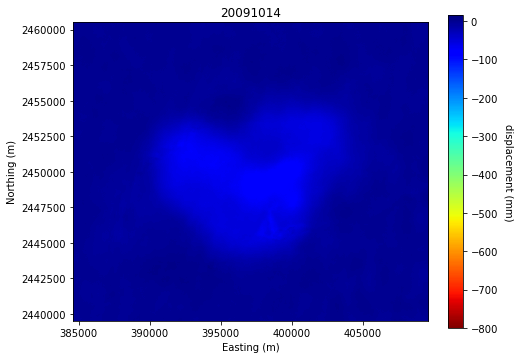

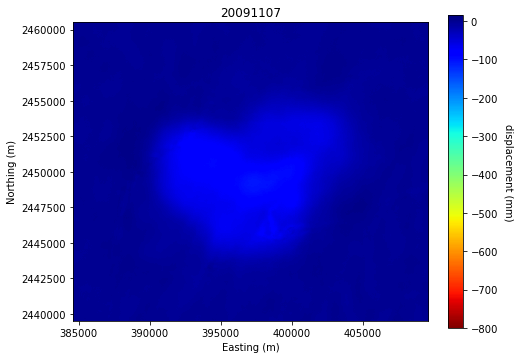

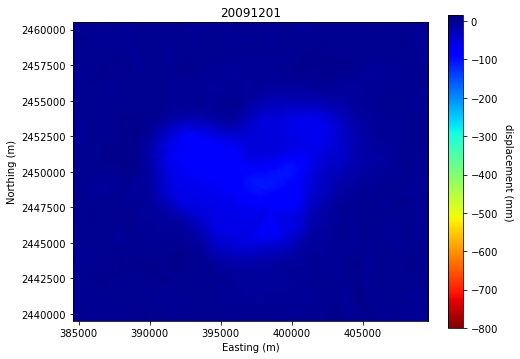

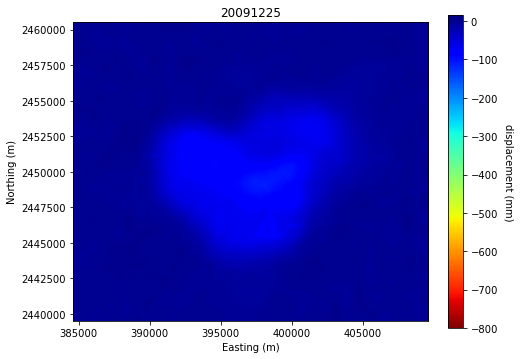

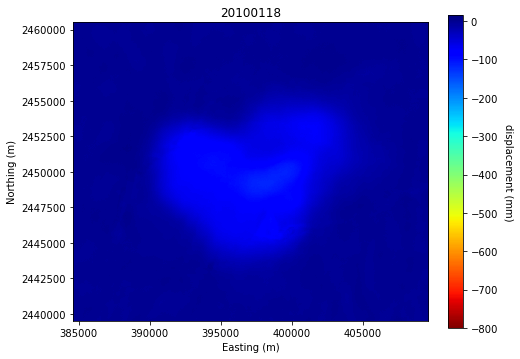

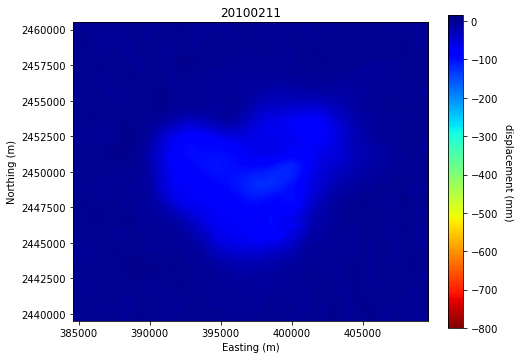

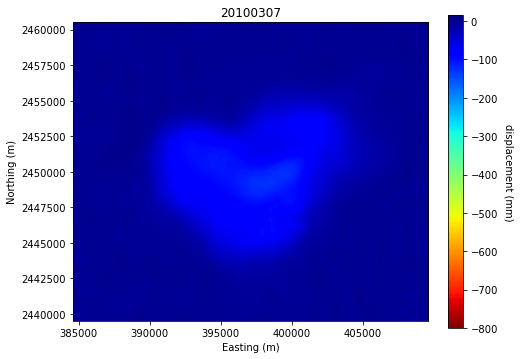

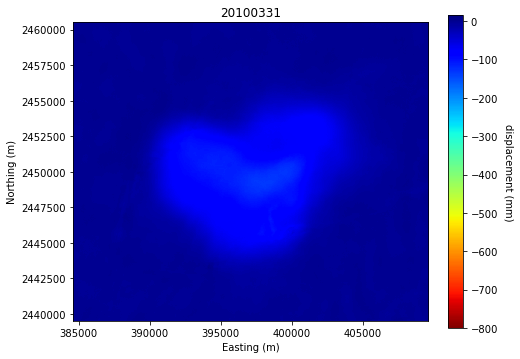

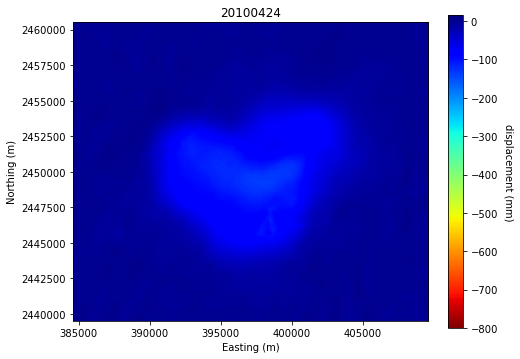

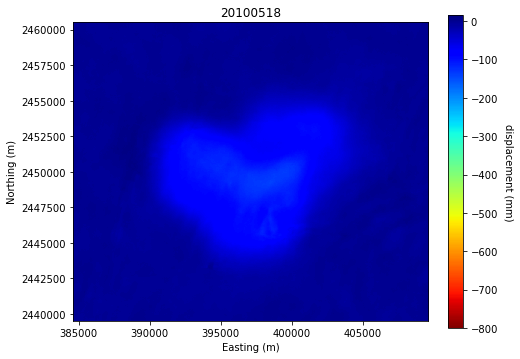

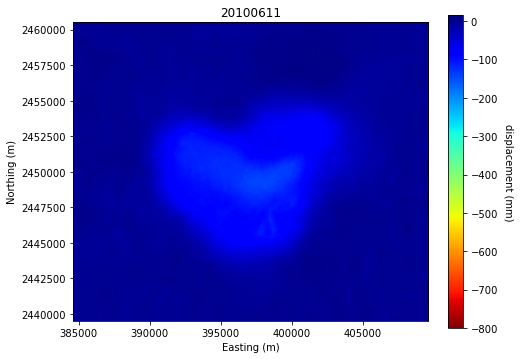

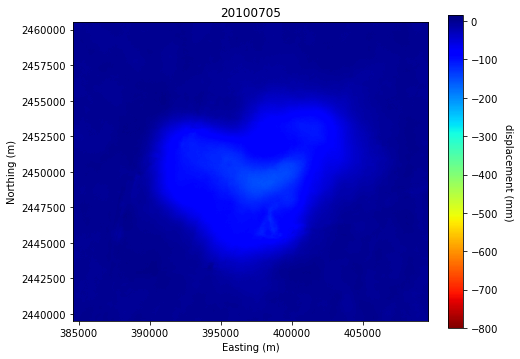

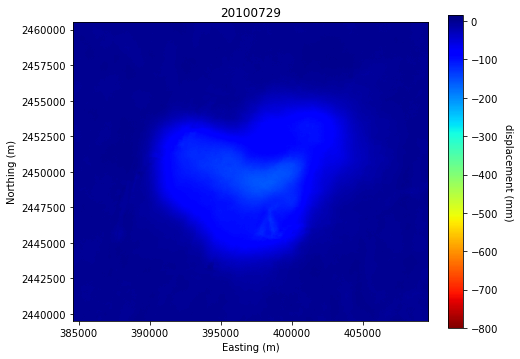

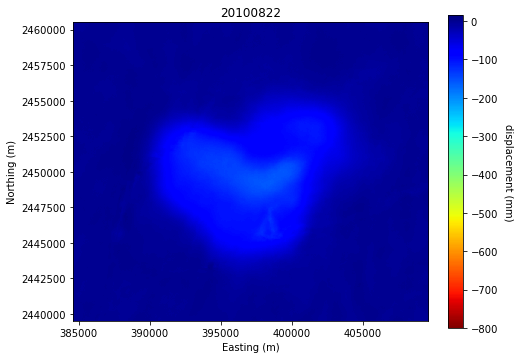

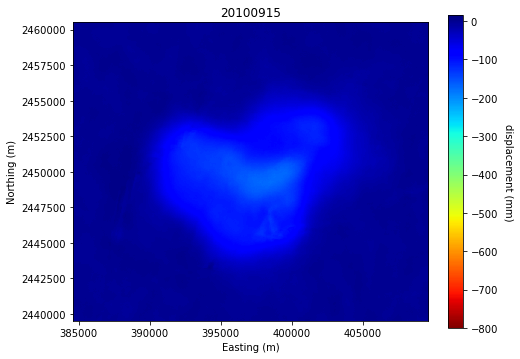

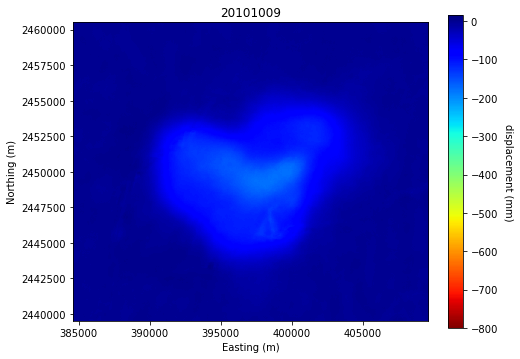

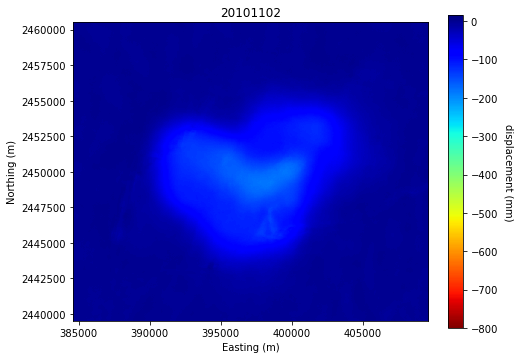

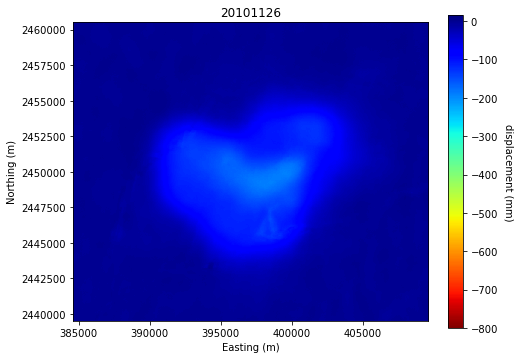

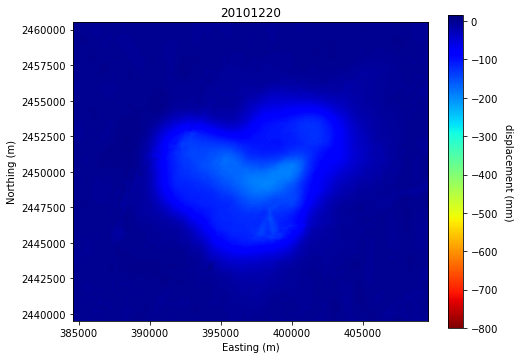

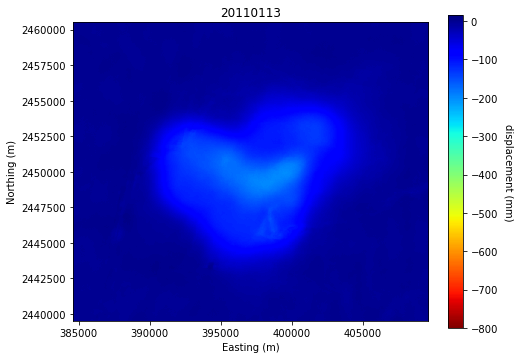

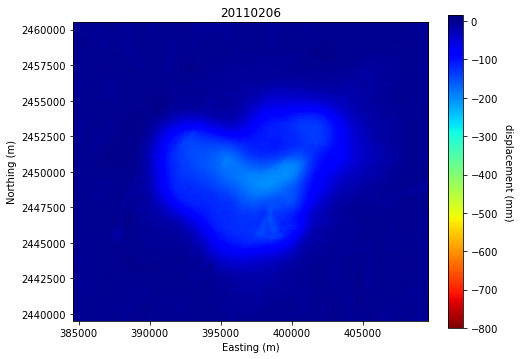

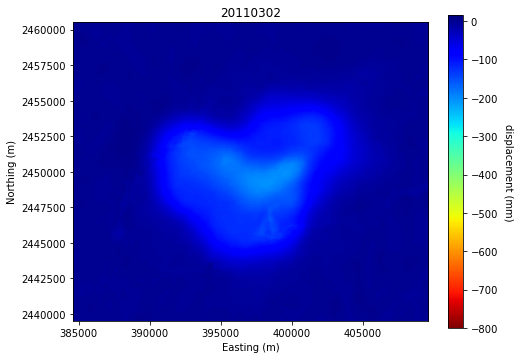

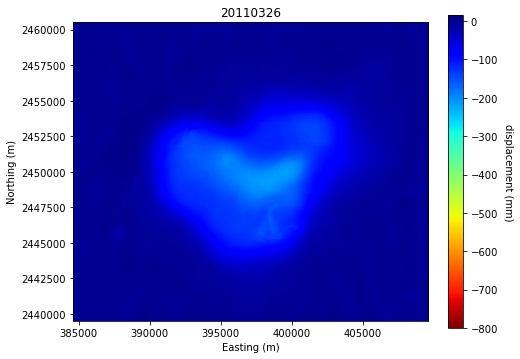

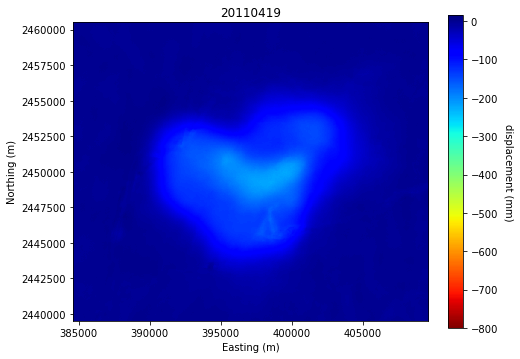

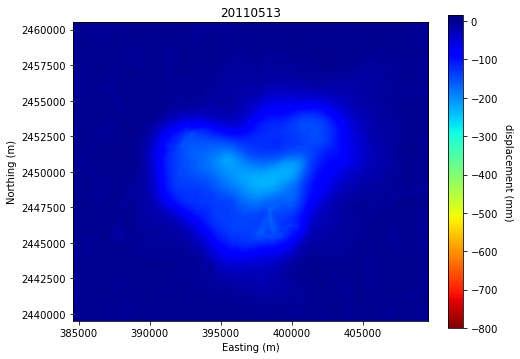

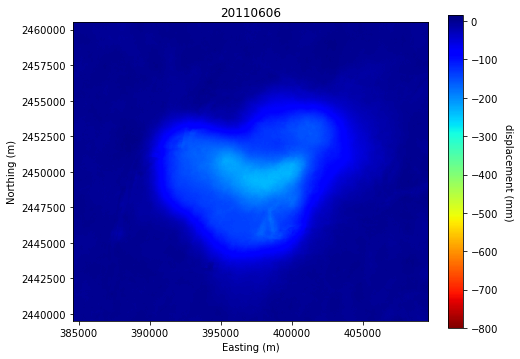

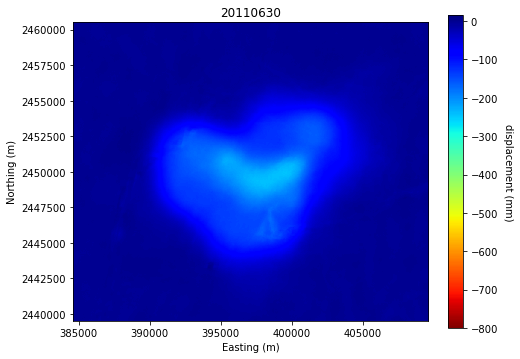

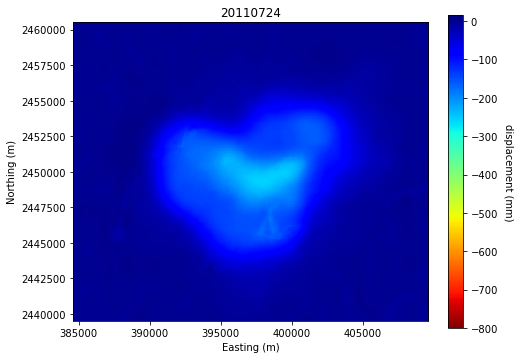

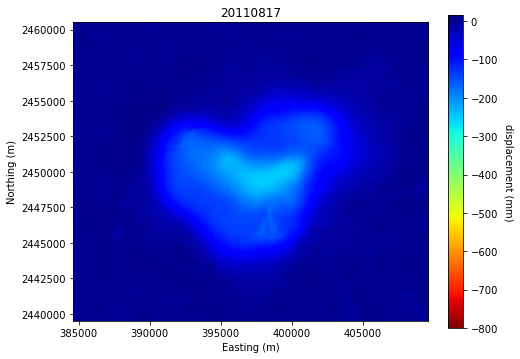

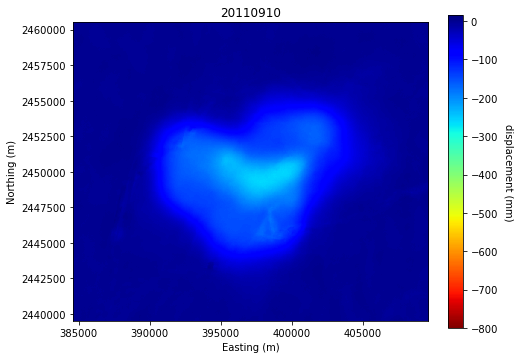

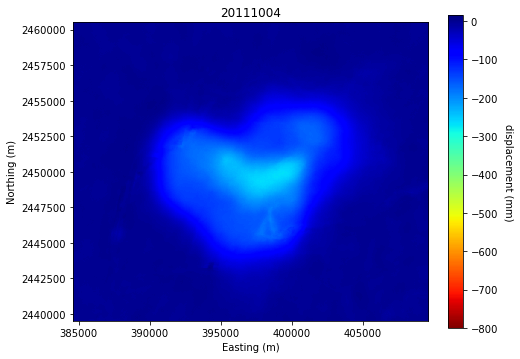

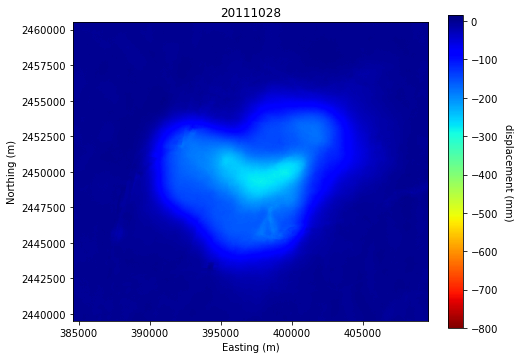

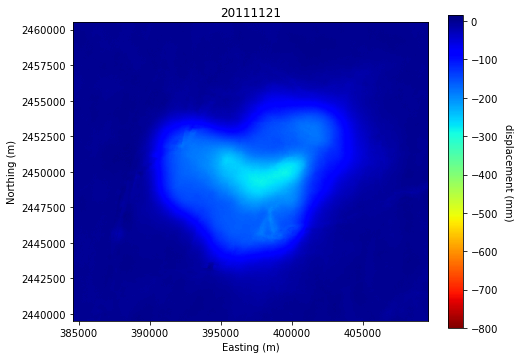

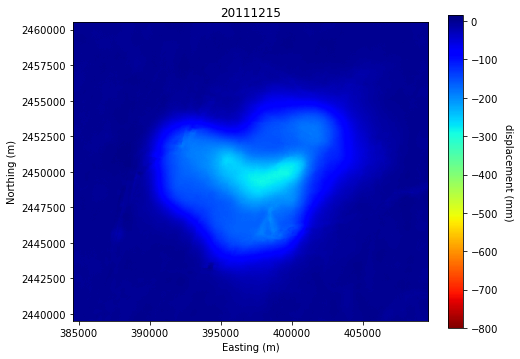

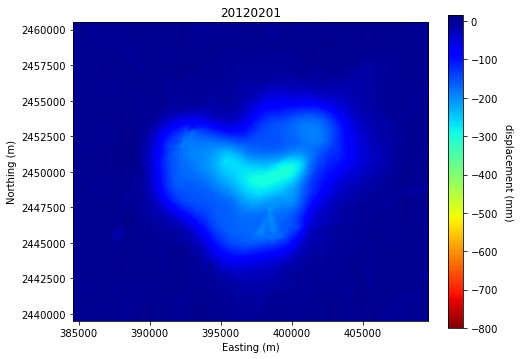

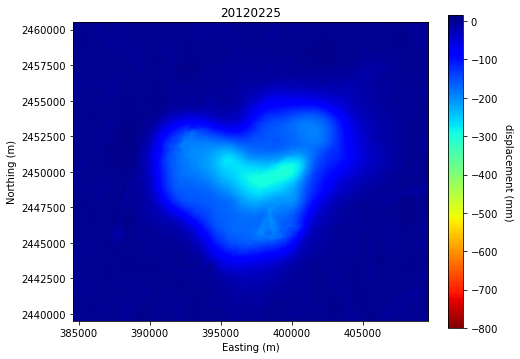

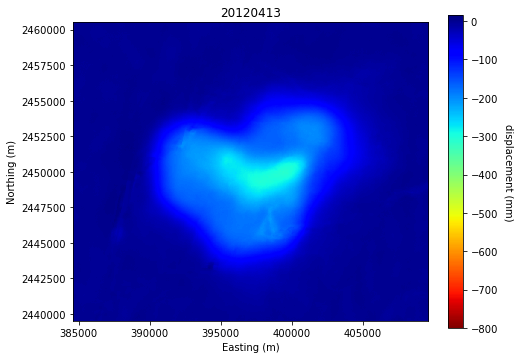

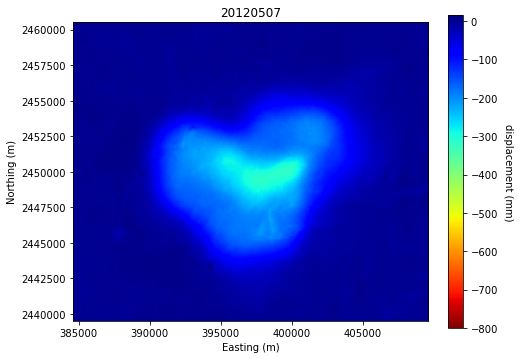

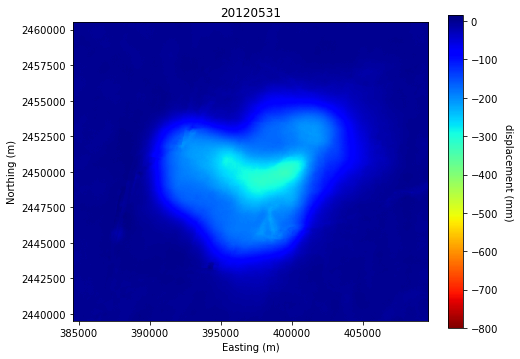

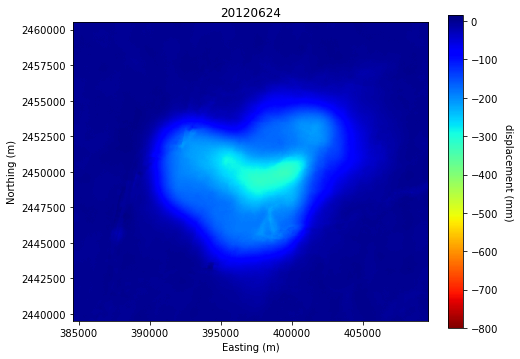

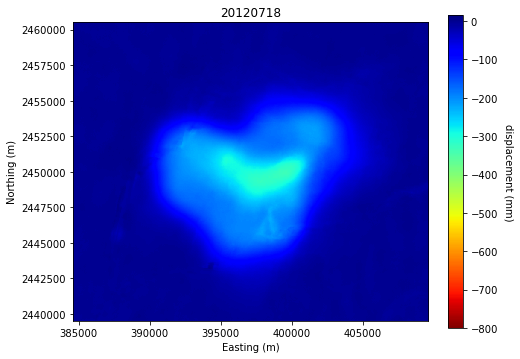

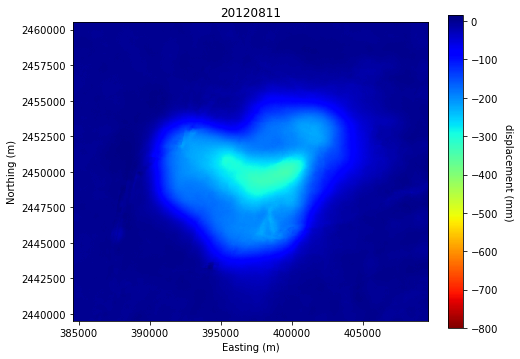

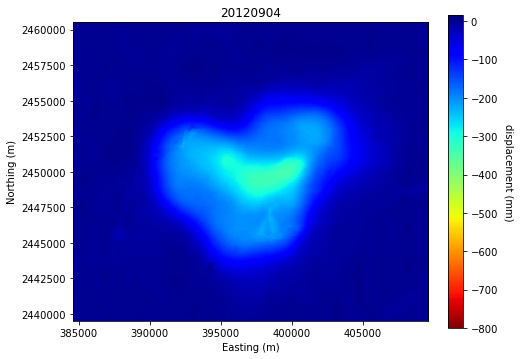

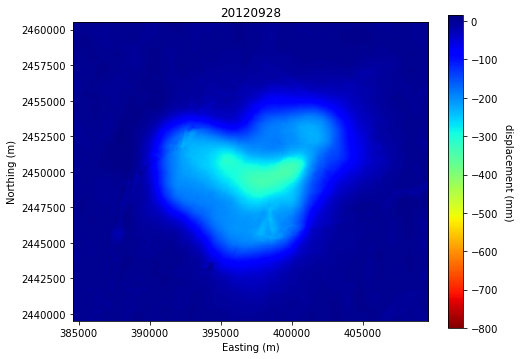

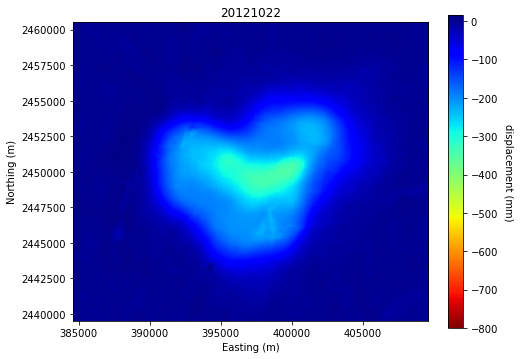

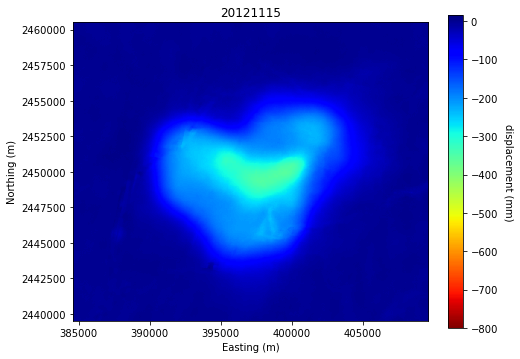

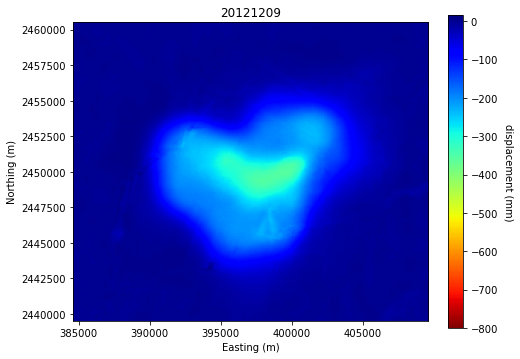

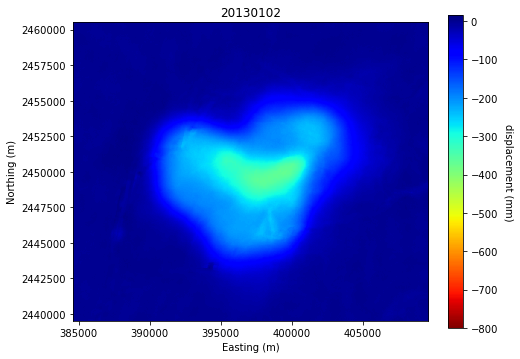

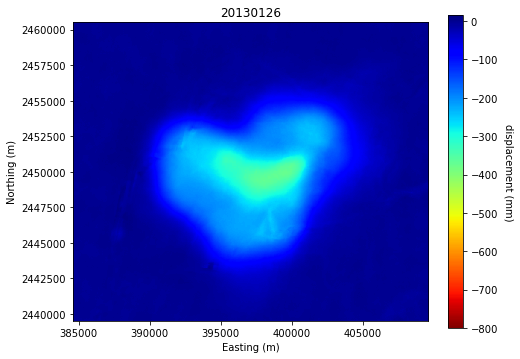

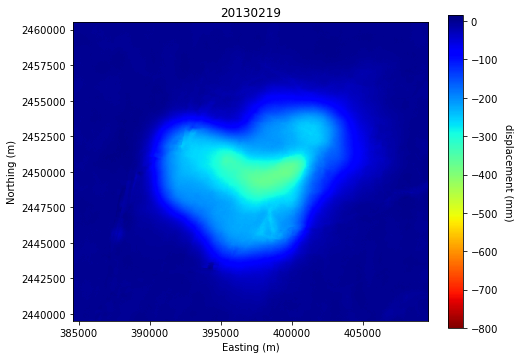

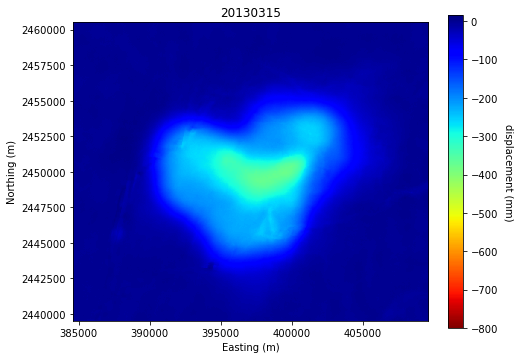

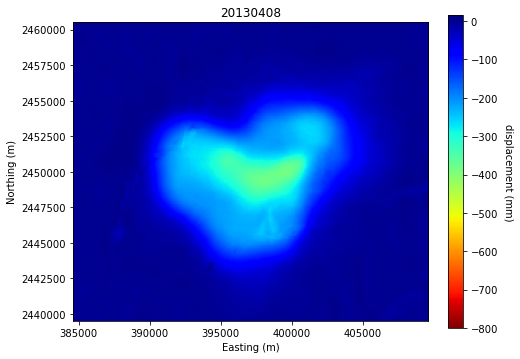

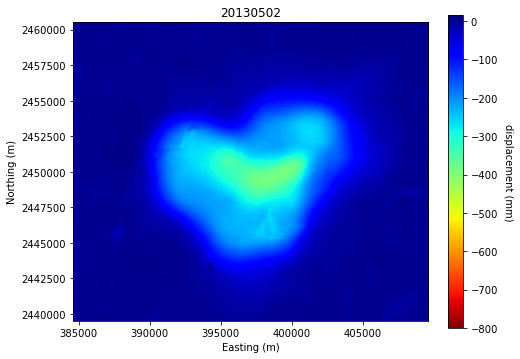

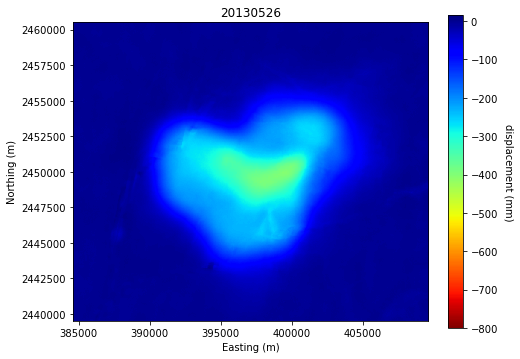

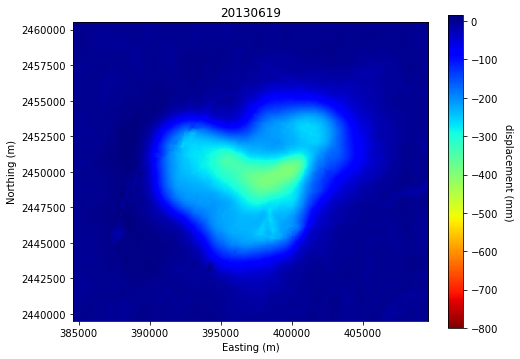

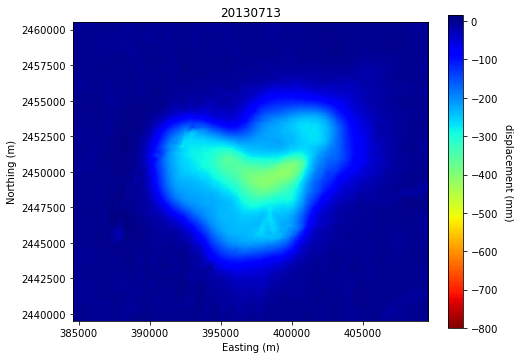

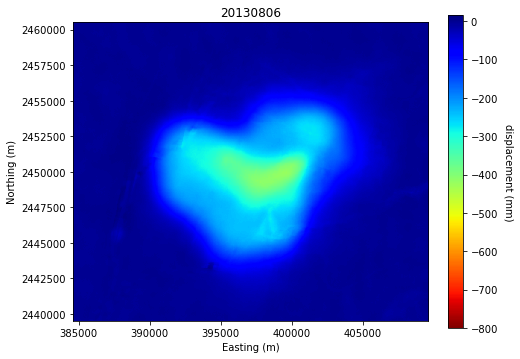

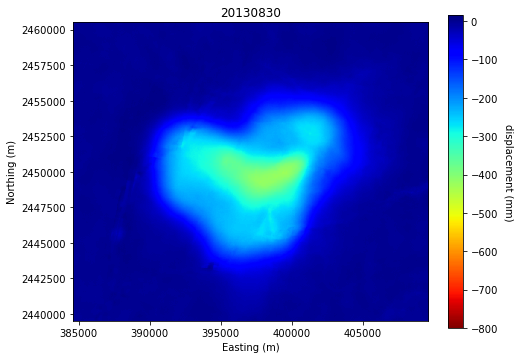

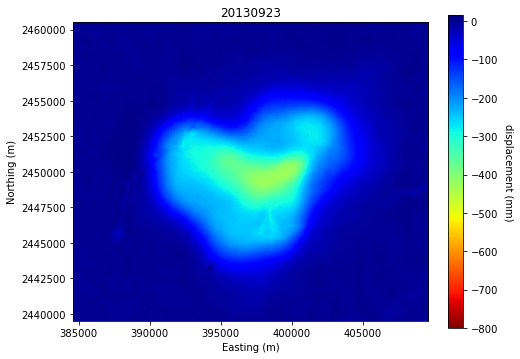

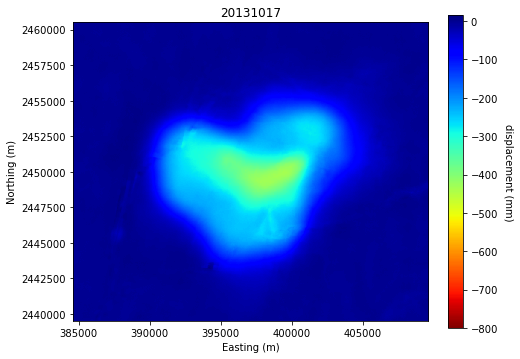

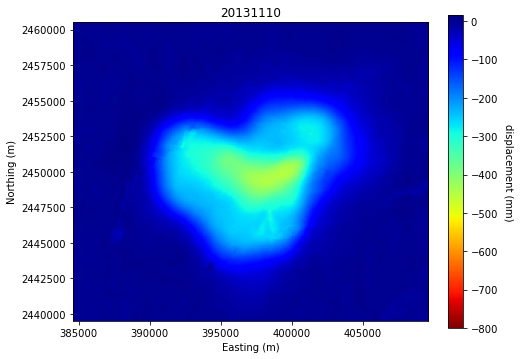

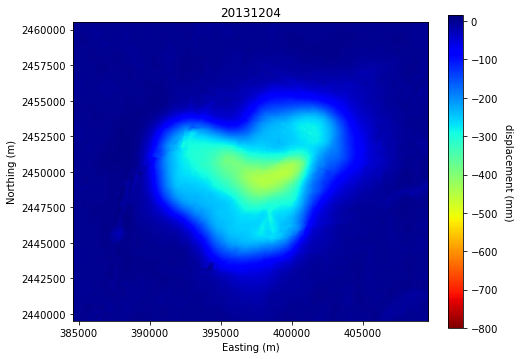

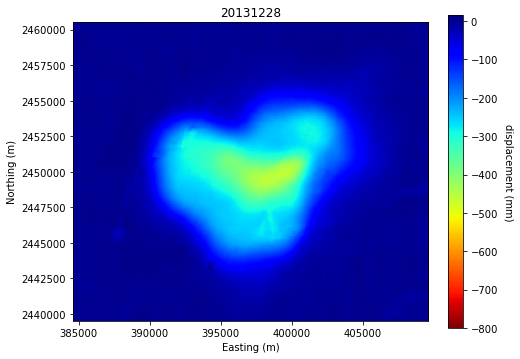

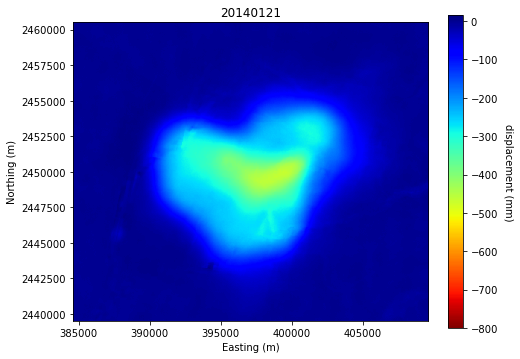

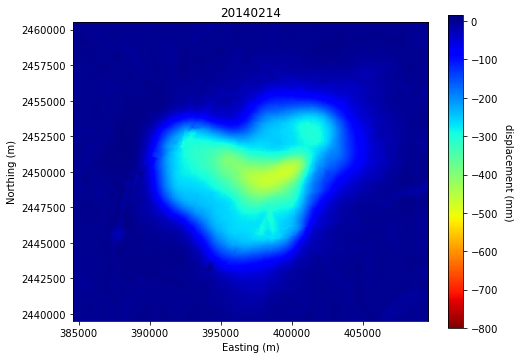

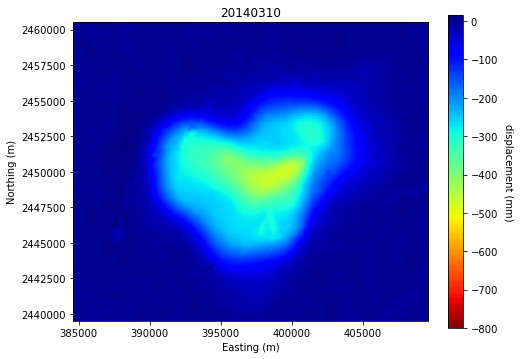

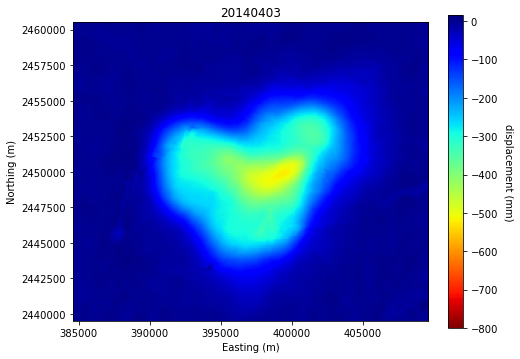

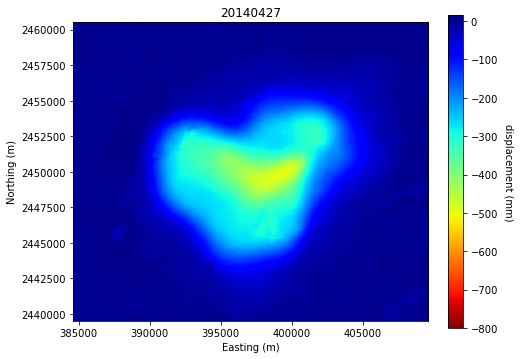

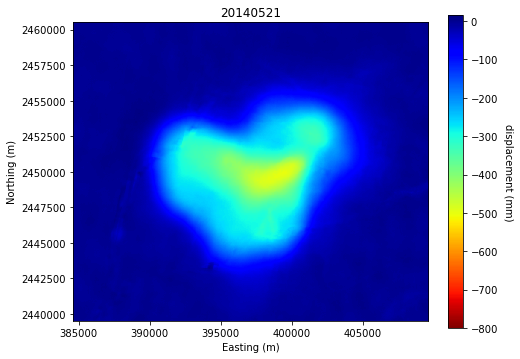

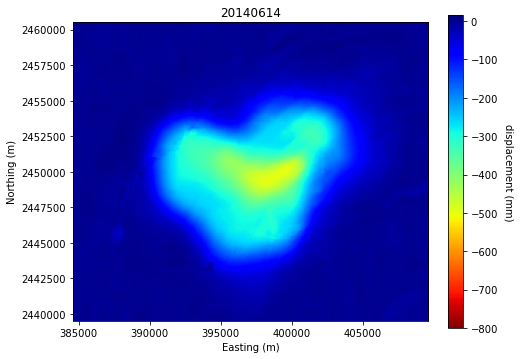

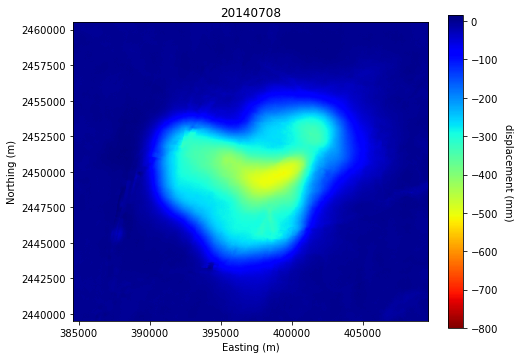

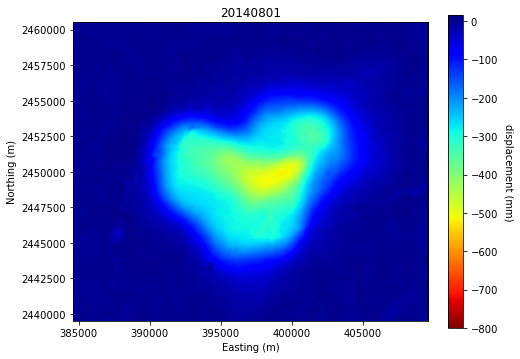

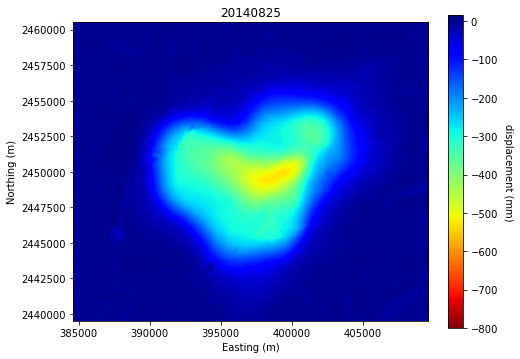

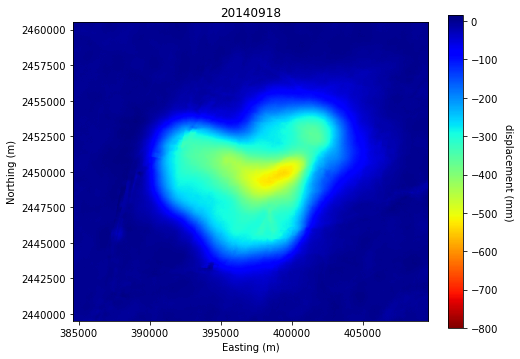

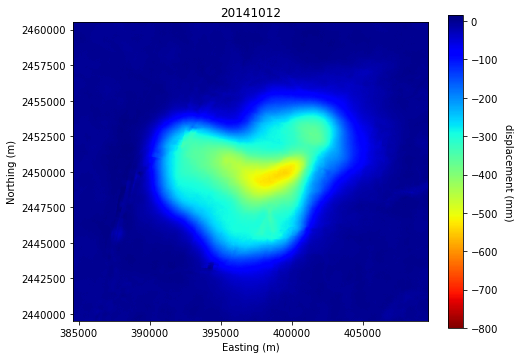

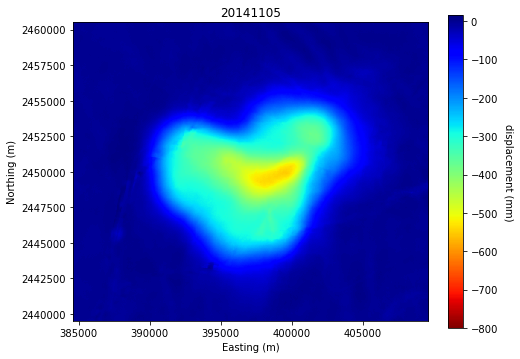

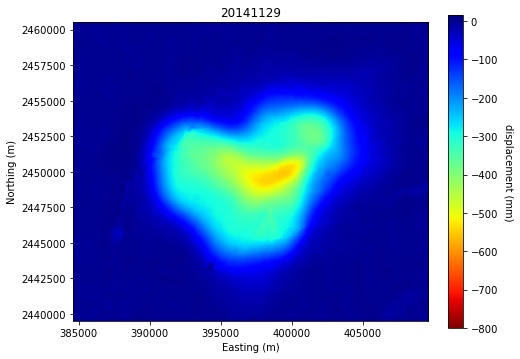

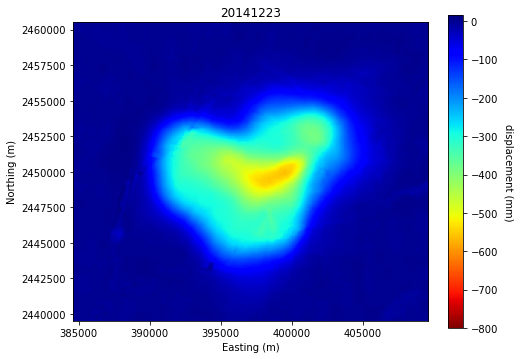

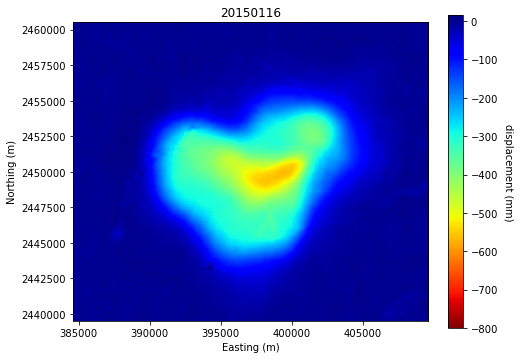

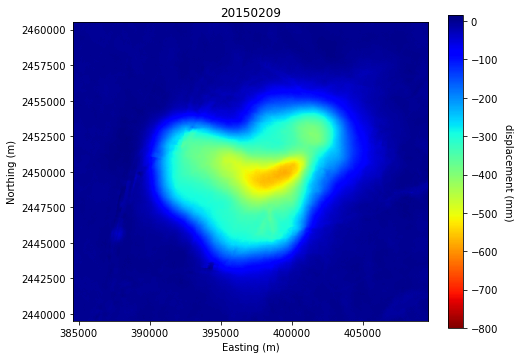

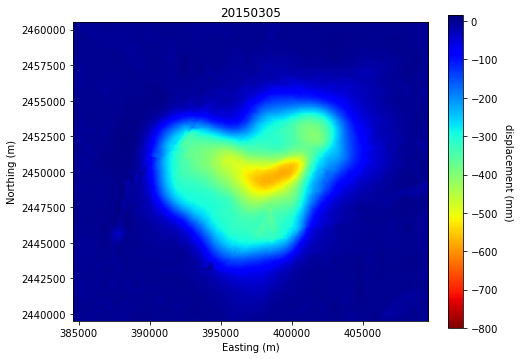

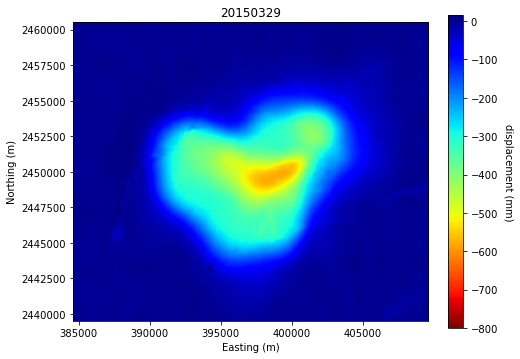

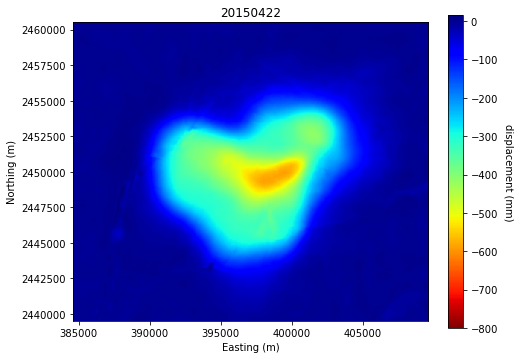

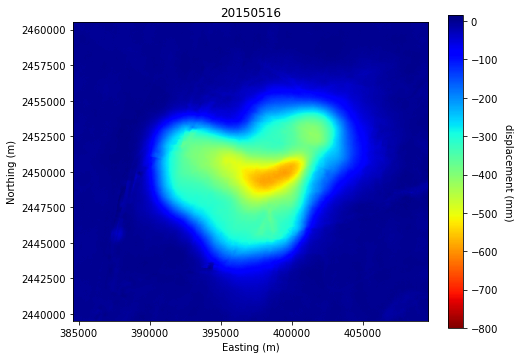

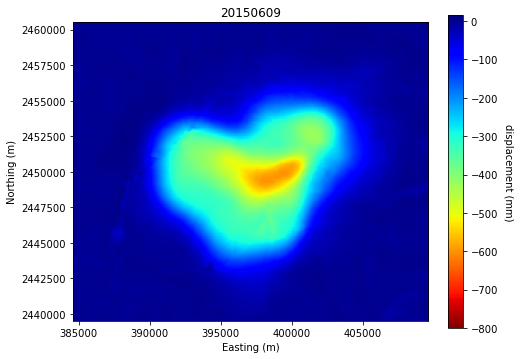

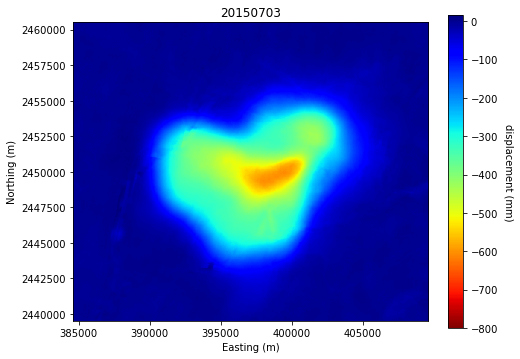

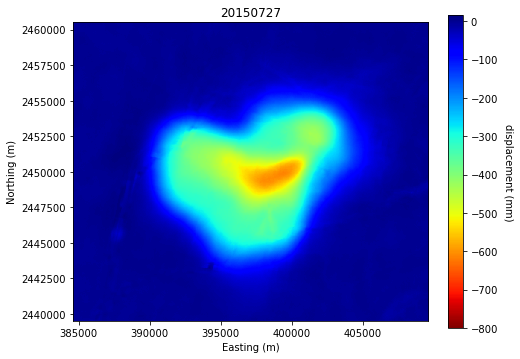

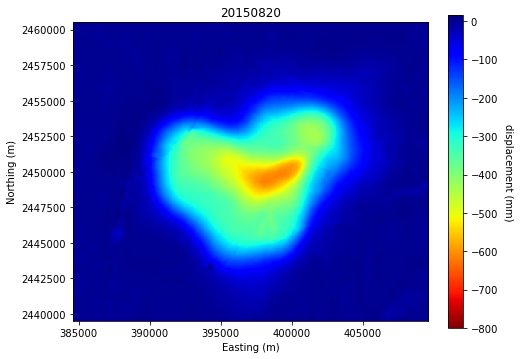

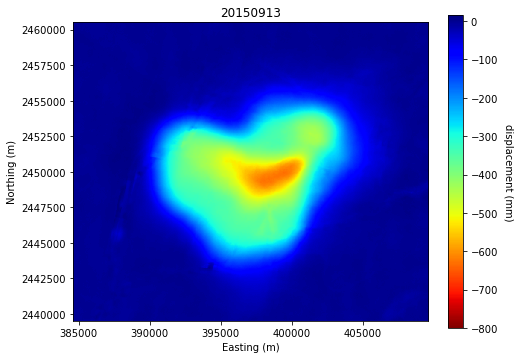

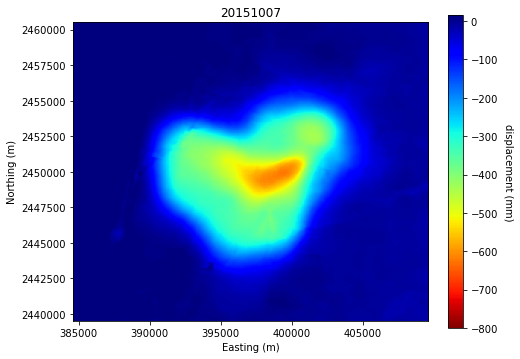

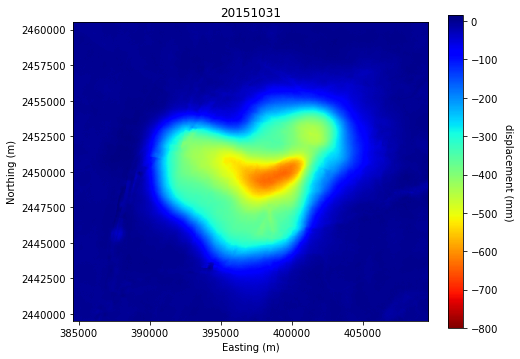

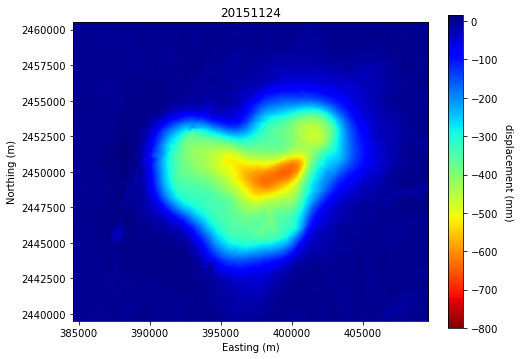

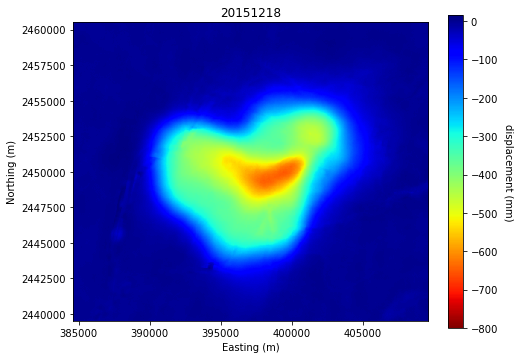

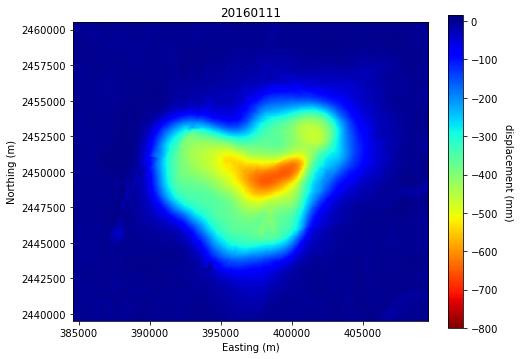

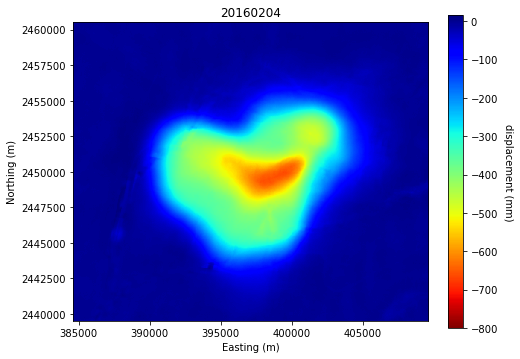

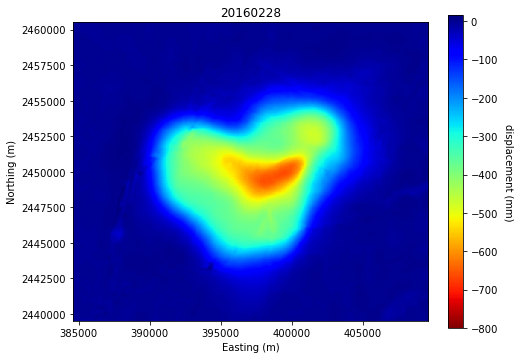

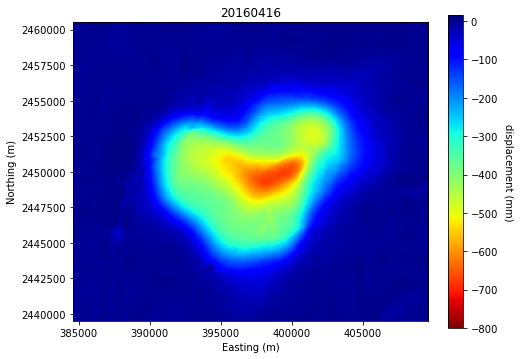

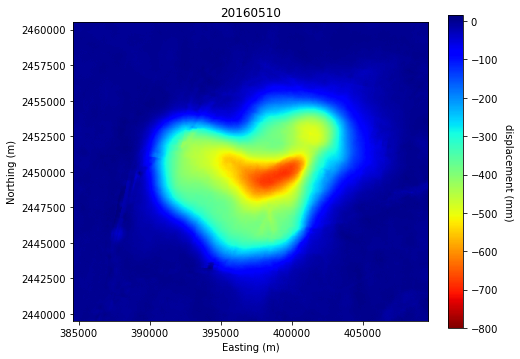

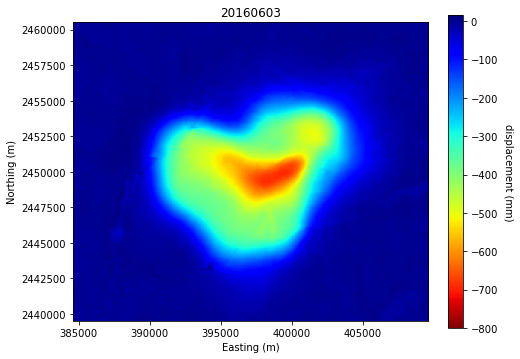

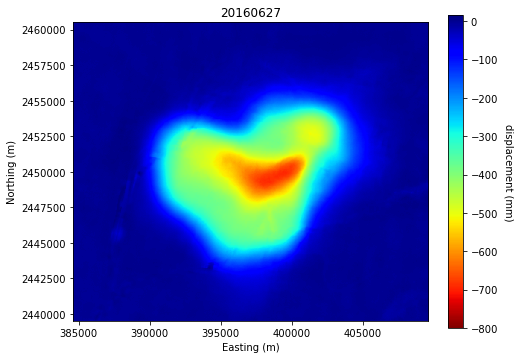

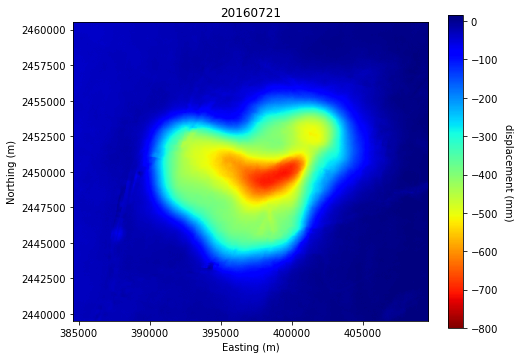

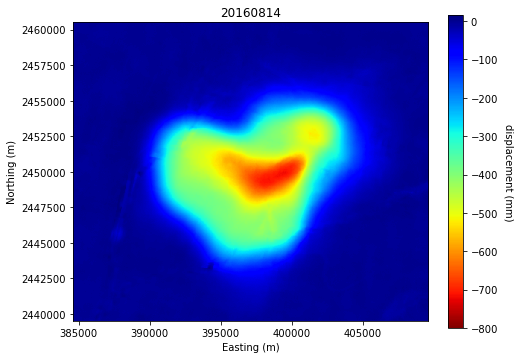

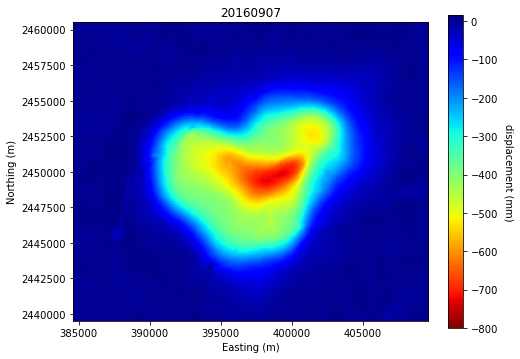

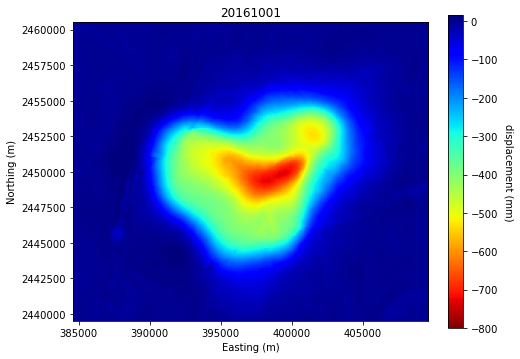

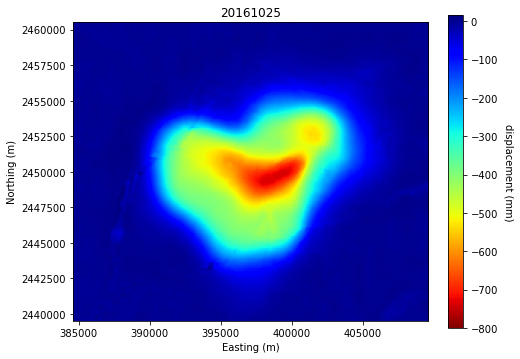

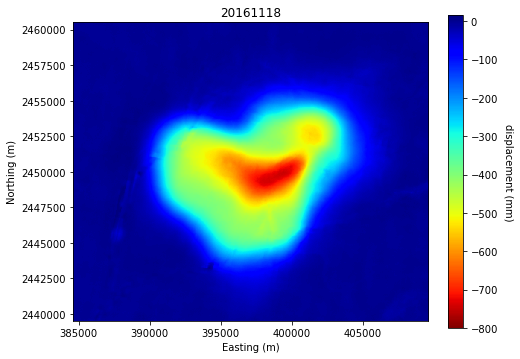

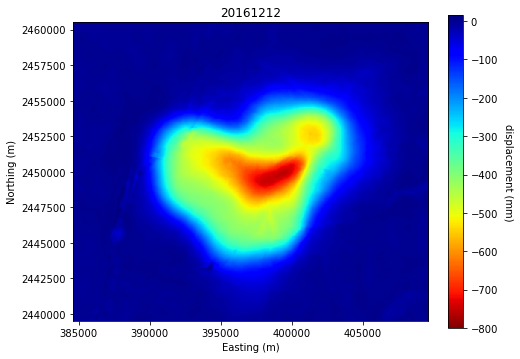

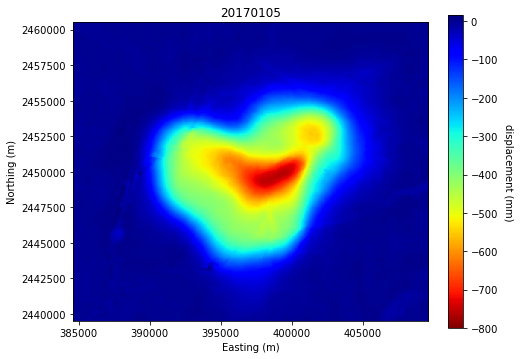

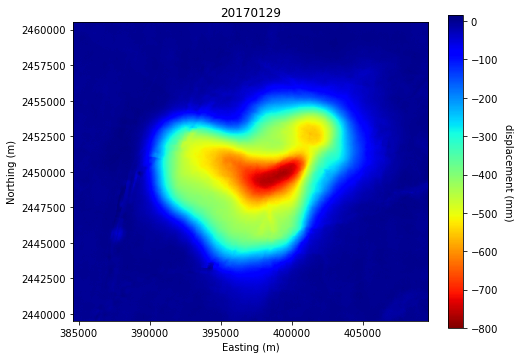

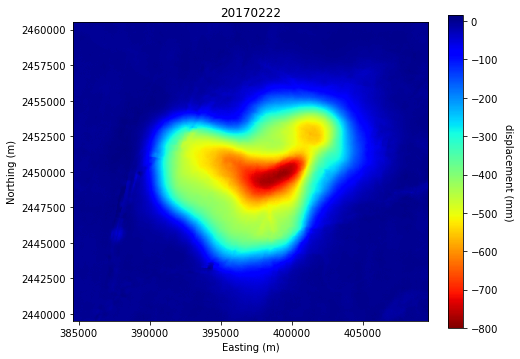

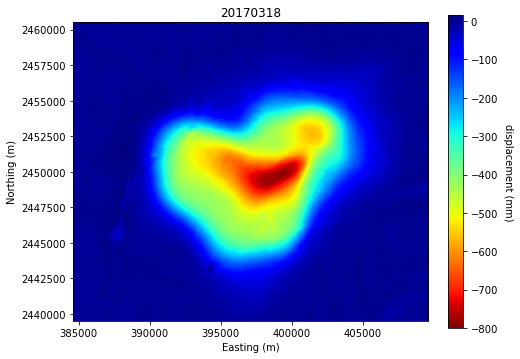

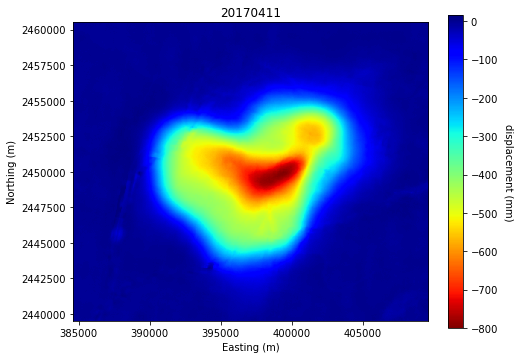

In [2]:
# list of file names
filelist = sorted(glob.glob("Yibal_VER_Deformation_Subset/*.tif"))
# obtaining the extent coordinates fron one file
ds = gdal.Open('Yibal_VER_Deformation_Subset/20100118.ver.geo.tif')
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3]

data={}
# obtaining time and julian date
time=[]
jul_date=[]
fmt = '%Y%m%d'
for i in filelist:
    name=i.split('/')
    name2=name[1].split('.')
    time.append(name2[0])
    dt = datetime.datetime.strptime(name2[0], fmt)
    tt = dt.timetuple()
    jul_date.append(tt.tm_year+(tt.tm_yday/365.))
#print time
# obtaining deformation maps
data={}
for n,i in enumerate(filelist):
    img = gdal.Open(i)
    array=img.ReadAsArray()
# converting from m to mm
    data[time[n]]=array*1000
# pltting deformation map
    fig = plt.figure(figsize=(7,7))
    plt.imshow(data[time[n]],cmap=cm.jet_r,vmin=-\
    800,vmax=15,extent=[minx,maxx,miny,maxy])
    plt.title(time[n])
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    cbar=plt.colorbar(fraction=0.04, pad=0.05)
    cbar.set_label('displacement (mm)', rotation=270\
                ,labelpad=15)
    #print np.min(data[time[n]]),np.max(data[time[n]])
    plt.savefig('images/%s.jpg'%(time[n]),bbox_inches=\
                'tight')
    
# gif movie of defermation evolution
#cmd = 'convert -delay 100 -loop 0 images/*.jpg images/movie.gif'
#os.system(cmd)

### obtaining velocity map

Minimum Velocity: -91.0063664357 Maximum Velocity: 2.66425326322


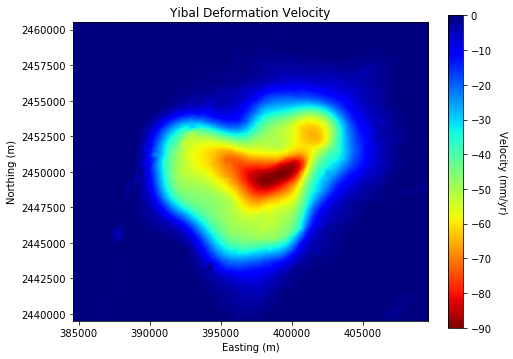

In [3]:
# array to include velocity map
vel=np.zeros(data['20080715'].shape)
# obtaining velocity for each pixel using 
#linear regression slope equation
for r in xrange(0,vel.shape[0]):
        for c in xrange(0,vel.shape[1]):
            disp =[]
            xy=[]
            x2=[]
            y2=[]
            for i,t in enumerate(jul_date):
                y=data['%s'%time[i]][r,c]
                disp.append(y)
                xy.append(y*t)
                x2.append(t**2)
                y2.append(y**2)
            vel[r,c]=((len(jul_date)*sum(xy))\
-(sum(jul_date)*sum(disp)))/((len(jul_date)*\
                    sum(x2))-sum(jul_date)**2)

# plotting velocity map
fig = plt.figure(figsize=(7,7))
plt.imshow(vel,cmap=cm.jet_r,vmin=-90,vmax=0,extent\
           =[minx,maxx,miny,maxy])
plt.title('Yibal Deformation Velocity')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
cbar=plt.colorbar(fraction=0.04, pad=0.05)
cbar.set_label('Velocity (mm/yr)', rotation=270,\
               labelpad=15)
print 'Minimum Velocity:',np.min(vel),'Maximum Velocity:',np.max(vel)
plt.savefig('images/vel3.jpg',bbox_inches='tight')

In [4]:
print 'Total area affected by subsidence is %.3f km'\
%(len(np.where(vel<-3)[0])*30.*30/(1000*1000))
print 'Total area affected by subsidence of more'\
,' than 10 mm/yr is %.3f km'\
%(len(np.where(vel<-10)[0])*30.*30/(1000*1000))
print 'Total area affected by subsidence of more'\
' than 30 mm/yr is %.3f km'\
%(len(np.where(vel<-30)[0])*30.*30/(1000*1000))
print 'Total area affected by subsidence of more'\
' than 50 mm/yr is %.3f km'\
%(len(np.where(vel<-50)[0])*30.*30/(1000*1000))
print 'Total area affected by subsidence of more'\
' than 70 mm/yr is %.3f km'\
%(len(np.where(vel<-70)[0])*30.*30/(1000*1000))

Total area affected by subsidence is 193.418 km
Total area affected by subsidence of more  than 10 mm/yr is 140.468 km
Total area affected by subsidence of more than 30 mm/yr is 92.904 km
Total area affected by subsidence of more than 50 mm/yr is 49.450 km
Total area affected by subsidence of more than 70 mm/yr is 11.392 km


### subsidence area in Yibal

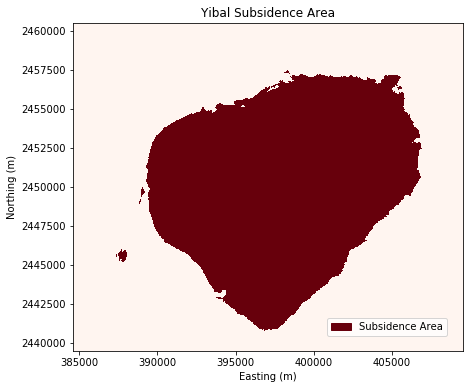

In [12]:
# array to include subsidence area
mask =[]
mask=np.zeros(data['20080715'].shape)
# finding pixels of subsidence area
for i in xrange(0,len(np.where(vel<-3)[0])):
    mask[np.where(vel<-3)[0][i],\
         np.where(vel<-3)[1][i]]=1
# plotting subsidence area    
fig = plt.figure(figsize=(7,7))
im = plt.imshow(mask,cmap=cm.Reds,extent=\
                [minx,maxx,miny,maxy])
plt.title('Yibal Subsidence Area')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
values = np.unique(mask.ravel())
colors = [ im.cmap(im.norm(value)) for value\
          in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[1],\
        label="Subsidence Area"%values[1])]
plt.legend(handles=patches, bbox_to_anchor=\
        (0.65, 0.1), loc=2, borderaxespad=0. )
plt.savefig('images/mask_yibal.jpg',bbox_inches='tight')
# saving a txt file of total subsidence
masked=mask==0
total_sub=[0]
sub_change=[0]
sub_total_file = open('Yibal_sub_diff2.txt', 'w')
for n in xrange(0,len(data.keys())):
    if n ==0:
        sub_total_file.write("%f\t%f\t%f\t%f\t\n" %(jul_date[n],0,0,0))
    else:
        disp_masked1=data['%s'%time[n]][~masked]
        disp_masked2=data['%s'%time[n-1]][~masked] 
        sub=sum(disp_masked1)
        d=((jul_date[n]-jul_date[n-1]))
        change = (disp_masked1-disp_masked2)/d
        change_sum= abs(sum(change[change<0]))
        mean = np.mean(change[change<0])*-1
        total_sub.append(sub)
        sub_change.append(change_sum)
        sub_total_file.write("%f\t%f\t%f\t%f\t\n" %(jul_date[n],sub,change_sum,mean))